##I - Introduction

#####2018 a été une année décisive dans le NLP. L'apprentissage par transfert, en particulier des modèles tels que ELMO d'Allen AI, Open-GPT d'OpenAI et BERT de Google, a fourni au reste de la communauté NLP des modèles pré-entraînés qui pourraient facilement avec moins de données et moins de temps de calcul être affinés et mis en œuvre pour produire des résultats qui dépasse the state of the art. Dans ce projet,nous allons montrer comment utiliser BERT avec la bibliothèque PyTorch pour affiner rapidement et efficacement un modèle de classification des logs d'Openstack, où notre objectif sera détecter les anomalies dans des futurs logs.


- **Dataset** - nous allons utiliser une DT open Source d'openstack mais il est sous forme d'un Filelog donc on avait besoin d'utiliser excel(On peut utiliser Python mais excel reste simple) pour insérer les logs dans des dataframes.

- **Objectif** - developper une solution qui permet de detecter les anomalies dans les logs.

- **Methodologie** - nous allons considerer comme nous avons un probleme de text classification et construire un deep learning model pour attiendre l'objectif.

#II- Different Models 
Il existe plusieurs types de modèles qui pourraient être utilisés pour créer la solution pour la classification de texte. Quelques exemples sont :


*   **1D- Conv Net** : 
les CNN peuvent être utilisés pour la classification des textes. **Avantage**: ils sont plus rapides à s'entraîner. En fait, un modèle CNN pourrait atteindre une précision décente **Disdvantage**: ils ne parviennent pas à capturer les dépendances à long terme dans le texte et ne capturent pas les informations séquentielles dans le texte.

*   **Modèles basés sur RNN (LSTM, GRU)** : **Avantage**: ils peuvent capturer la nature séquentielle d'un texte. **Inconvénient** : Plus lent à s'entraîner.

* **Modèles basés sur des transformers (BERT, GPT2)** -
Les modèles basés sur des transformers exploite plusieurs unités Transformer et un mécanisme d'attention à multihead. L'avantage est qu'ils se concentrent uniquement sur le mécanisme d'attention. 

####Dans ce projet nous allons focaliser sur un model basé sur des transformers(encoder partie) qui est le model Bert 


# III- Bert For anomaly detection

### 1. Importing libraries and modules

In [2]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 901kB 36.2MB/s 
     |████████████████████████████████| 3.3MB 35.1MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import re
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight


###2. Loading Data

####**Importing files from Google Drive in Colab**
notre dataset est stockée dans Google Drive donc nous avons besoin de 
lier notre compte Google Drive avec notre notebook.
1. La première étape consiste à monter notre Google Drive en exécutant le code en dessous.
2.  nous obtenons le code d'autorisation en nous connectant à notre compte Google.
3.   nous collons le code d'autorisation et nous appuyons sur Entrée.

In [4]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
PATH_normal=r'/gdrive/My Drive/normal.xlsx'
PATH_abnormal=r'/gdrive/My Drive/abnormal.xlsx'

In [ ]:
data_normal = pd.read_excel(PATH_normal)
data_abnormal = pd.read_excel(PATH_abnormal)

In [ ]:
data_normal.to_csv(r'/gdrive/My Drive/normal1.csv')
data_abnormal.to_csv(r'/gdrive/My Drive/abnormal1.csv')

In [5]:
df_normal = pd.read_csv(r'/gdrive/My Drive/normal.csv')
df_abnormal = pd.read_csv(r'/gdrive/My Drive/abnormal.csv')

In [6]:
df_normal=df_normal[['log']]

In [7]:
df_abnormal=df_abnormal[['log']]

###3. Data Preprocessing

* Ajouter les labels (0 normal log, 1 abnormal log)

In [8]:
df_normal['label']=0
df_abnormal['label']=1

* concatenate and shuffle data

In [9]:
#concatinate
df=pd.concat([df_normal,df_abnormal])
# Shuffle the data
df = shuffle(df).reset_index(drop=True)
df.sample(10)

,log,label
6413,nova-api.log.1.2017-05-17_12:02:19 2017-05-16 ...,0
1265,nova-api.log.2017-05-14_21:27:04 2017-05-14 19...,1
6303,nova-api.log.1.2017-05-17_12:02:19 2017-05-16 ...,0
5748,nova-api.log.1.2017-05-17_12:02:19 2017-05-16 ...,0
6072,nova-api.log.2017-05-14_21:27:04 2017-05-14 19...,1
3272,nova-compute.log.1.2017-05-17_12:02:35 2017-05...,0
7303,nova-api.log.2017-05-14_21:27:04 2017-05-14 20...,1
8447,nova-api.log.2017-05-14_21:27:04 2017-05-14 19...,1
259,nova-api.log.2017-05-14_21:27:04 2017-05-14 19...,1
3083,nova-compute.log.2017-05-14_21:27:09 2017-05-1...,1


In [10]:
df.shape

(8923, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8923 entries, 0 to 8922
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   log     8923 non-null   object
 1   label   8923 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 139.5+ KB


In [12]:
print('Number of normal log : ', df["label"].value_counts()[0])
print('Number of abnormal log : ', df["label"].value_counts()[1])

Number of normal log :  5703
Number of abnormal log :  3220


* Nous supprimons ensuite les caractères non alphanumériques.

In [13]:
def clean_data(log):
    log = re.sub("'", "", log)
    log = re.sub("(\\W)+", " ", log)
    log = log.lower()
    return log

df['log'] = df['log'].apply(clean_data)

* Split the dataset into train(80%, validation 10% and test sets 10%)

In [14]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['log'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])

# val set & test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

###4. Tokenization

* Bert accepte un type spécifique des inputs pour y répondre nous sommes tenus de:
1. Ajouter des tokens spéciaux au début[CLS] et à la fin[SEP] de chaque log.
2. Compléter et tronquer toutes les logs à une seule longueur constante "padding".
3. Différencier explicitement les vrais tokens des tokens de remplissage avec le "attention mask" 1 vrai 0 vide.

PS: l'output du dernier transformer(12eme), seul le premier embeddage (correspondant au token [CLS]) est utilisé par le classifieur.

In [15]:
# specify GPU
device = torch.device("cuda")

In [16]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

* obtenir une idée sur la longueur des logs

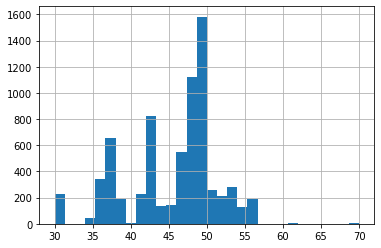

In [17]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

* Mesurer la longueur du plus long log

In [18]:
max_len = 0
for sent in df.log:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  198


* fixer la longueur des logs

In [19]:
max_seq_len = 100

* Tokenize DataSet

In [20]:
# tokenize & encode sequences training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
    max_length = max_seq_len,
    pad_to_max_length=True, # Pad & truncate all sentences.
    truncation=True,
    return_token_type_ids=False
)

# tokenize & encode sequences validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize & encode sequences test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


###5. Convert Data to Tensors(PyTorch Data Types)

Notre modèle attend des tenseurs PyTorch plutôt que numpy.ndarrays, donc convertissons toutes nos variables.

In [21]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

###6. Create DataLoaders

Nous allons également créer un itérateur pour notre ensemble de données à l'aide de la classe Torch DataLoader. Cela permet d'économiser de la mémoire pendant l'entraînement car, contrairement à une boucle for, avec un itérateur, l'ensemble de données n'a pas besoin d'être chargé en mémoire.

In [22]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

###7. Define Model Architecture

In [23]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
bert.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

* Freeze BERT Parameters

In [26]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [27]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.2)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [28]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Tell pytorch to run this model on the GPU.
model = model.to(device)

Maintenant que notre modèle est chargé, nous devons récupérer les hyperparamètres d'entraînement.
- Batch size: 32 (nous en avons choisi 32 lors de la création du DataLoaders).
- Learning rate (Adam):nous utiliserons 1e-3.
- Nombre d'époques:nous en utiliserons 10.

In [29]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr =2e-5)

* Find Class Weights

In [30]:
#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.78233231 1.38548137]


* convert class weights to tensor

In [32]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

###8. Fine-Tune BERT

In [33]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [34]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

###9. Model Training

In [35]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.693
Validation Loss: 0.685

 Epoch 2 / 5
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.688
Validation Loss: 0.680

 Epoch 3 / 5
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.685
Validation Loss: 0.676

 Epoch 4 / 5
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.683
Validation Loss: 0.671

 Epoch 5 / 5
  Batch    50  of    224.
  Batch   100  of    224.
  Batch   150  of    224.
  Batch   200  of    224.

Evaluating...

Training Loss: 0.679
Validation Loss: 0.668


* Jetons un coup d'œil au training loss:

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("batch")
plt.ylabel("Loss")

plt.show()

###10. Get Predictions for Test Data

In [36]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [37]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       571
           1       0.68      0.64      0.66       322

    accuracy                           0.76       893
   macro avg       0.74      0.74      0.74       893
weighted avg       0.76      0.76      0.76       893



In [38]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,476,95
1,117,205
